In [ ]:
print("HI")

In [ ]:
""" data loading and improting numbpy pandas

"""
import numpy as np
import pandas as pd

ohlc = pd.read_parquet("./src/DAT_ASCII_XAUUSD_M1_2024.parquet")

print (ohlc)

In [ ]:
"""Enterprise-Level Data Resampling System
======================================

A comprehensive, production-ready system for resampling financial time series data
with advanced features including validation, logging, caching, and extensibility.

Author: Enterprise Data Team
Version: 1.0.0
"""

import pandas as pd
import numpy as np
import logging
from typing import Dict, List, Optional, Union, Callable, Any
from dataclasses import dataclass, field
from datetime import datetime, timedelta
from pathlib import Path
import json
import warnings
from abc import ABC, abstractmethod
from functools import wraps
import hashlib
from concurrent.futures import ThreadPoolExecutor, as_completed
import time


# Configure logging
def setup_logging(log_level: str = "INFO", log_file: Optional[str] = None) -> logging.Logger:
    """Setup enterprise logging configuration."""
    logger = logging.getLogger("DataResampler")
    logger.setLevel(getattr(logging, log_level.upper()))

    # Clear existing handlers
    for handler in logger.handlers[:]:
        logger.removeHandler(handler)

    # Create formatter
    formatter = logging.Formatter(
        '%(asctime)s - %(name)s - %(levelname)s - %(funcName)s:%(lineno)d - %(message)s'
    )

    # Console handler
    console_handler = logging.StreamHandler()
    console_handler.setFormatter(formatter)
    logger.addHandler(console_handler)

    # File handler if specified
    if log_file:
        file_handler = logging.FileHandler(log_file)
        file_handler.setFormatter(formatter)
        logger.addHandler(file_handler)

    return logger


# Custom Exceptions
class DataResamplerError(Exception):
    """Base exception for data resampling operations."""
    pass


class ValidationError(DataResamplerError):
    """Raised when data validation fails."""
    pass


class ConfigurationError(DataResamplerError):
    """Raised when configuration is invalid."""
    pass


class ProcessingError(DataResamplerError):
    """Raised when data processing fails."""
    pass


# Configuration Management
@dataclass
class ResamplingConfig:
    """Configuration class for resampling operations."""

    # Core resampling settings
    default_period: str = '4H'
    supported_periods: List[str] = field(default_factory=lambda: [
        '1T', '5T', '15T', '30T', '1H', '2H', '4H', '6H', '12H', '1D', '1W', '1M'
    ])

    # Data validation settings
    required_columns: List[str] = field(default_factory=lambda: [
        'datetime', 'open', 'high', 'low', 'close', 'vol'
    ])
    numeric_columns: List[str] = field(default_factory=lambda: [
        'open', 'high', 'low', 'close', 'vol'
    ])

    # Processing settings
    drop_na_periods: bool = True
    validate_ohlc: bool = True
    min_data_points: int = 1
    max_gap_tolerance: str = '1D'

    # Performance settings
    enable_caching: bool = True
    cache_size_limit: int = 100  # Number of cached results
    parallel_processing: bool = False
    max_workers: int = 4

    # Output settings
    reset_index: bool = True
    datetime_column_name: str = 'datetime'

    @classmethod
    def from_file(cls, config_path: Union[str, Path]) -> 'ResamplingConfig':
        """Load configuration from JSON file."""
        try:
            with open(config_path, 'r') as f:
                config_dict = json.load(f)
            return cls(**config_dict)
        except (FileNotFoundError, json.JSONDecodeError) as e:
            raise ConfigurationError(f"Failed to load configuration: {e}")

    def save_to_file(self, config_path: Union[str, Path]) -> None:
        """Save configuration to JSON file."""
        config_dict = {
            k: v for k, v in self.__dict__.items()
            if not k.startswith('_')
        }
        with open(config_path, 'w') as f:
            json.dump(config_dict, f, indent=2, default=str)


# Date Filtering System
class EnterpriseDateFilter:
    """Enterprise-grade date filtering with comprehensive validation and error handling."""

    def __init__(self, logger: logging.Logger):
        self.logger = logger
        self.metrics = {
            'filter_operations': 0,
            'rows_filtered': 0,
            'invalid_dates_found': 0
        }

    def filter_by_date_range(
        self,
        df: pd.DataFrame,
        start_date: Union[str, datetime],
        end_date: Union[str, datetime],
        datetime_col: str = 'datetime',
        inclusive: str = 'both',
        date_format: Optional[str] = None,
        column_date_format: Optional[str] = None,
        handle_invalid: str = 'warn'  # 'warn', 'error', 'ignore'
    ) -> pd.DataFrame:
        """
        Enterprise-grade date filtering with comprehensive validation and error handling.

        Parameters:
            df (pd.DataFrame): Input DataFrame containing the datetime column.
            start_date (str or datetime): Start of the date range.
            end_date (str or datetime): End of the date range.
            datetime_col (str): Name of the datetime column in df.
            inclusive (str): Boundary inclusion behavior ('both', 'left', 'right', 'neither').
            date_format (str, optional): Format of input date strings.
            column_date_format (str, optional): Format of the datetime column.
            handle_invalid (str): How to handle invalid dates ('warn', 'error', 'ignore').

        Returns:
            pd.DataFrame: Filtered DataFrame containing rows within the specified date range.

        Raises:
            ValidationError: If inputs are invalid or datetime conversion fails.
        """
        start_time = time.time()
        original_rows = len(df)

        try:
            # Input validation
            self._validate_filter_inputs(df, datetime_col, inclusive, handle_invalid)

            # Convert and validate date range
            start_dt, end_dt = self._parse_and_validate_dates(
                start_date, end_date, date_format
            )

            # Process datetime column
            df = self._process_datetime_column(
                df, datetime_col, column_date_format, handle_invalid
            )

            # Apply date filtering
            filtered_df = self._apply_date_filter(
                df, datetime_col, start_dt, end_dt, inclusive
            )

            # Update metrics
            self.metrics['filter_operations'] += 1
            self.metrics['rows_filtered'] += original_rows - len(filtered_df)

            processing_time = time.time() - start_time
            self.logger.info(
                f"Date filtering completed: {original_rows} -> {len(filtered_df)} rows "
                f"(range: {start_dt.date()} to {end_dt.date()}, time: {processing_time:.3f}s)"
            )

            return filtered_df

        except Exception as e:
            self.logger.error(f"Date filtering failed: {str(e)}")
            raise ValidationError(f"Date filtering failed: {str(e)}") from e

    def filter_by_business_hours(
        self,
        df: pd.DataFrame,
        datetime_col: str = 'datetime',
        start_time: str = '09:30',
        end_time: str = '16:00',
        timezone: str = 'UTC'
    ) -> pd.DataFrame:
        """Filter data to business hours only."""
        try:
            df = df.copy()

            # Ensure datetime column is datetime type
            df[datetime_col] = pd.to_datetime(df[datetime_col])

            # Convert to specified timezone if needed
            if timezone != 'UTC':
                df[datetime_col] = df[datetime_col].dt.tz_convert(timezone)

            # Extract time component
            time_component = df[datetime_col].dt.time

            # Parse business hours
            start_time_obj = pd.to_datetime(start_time, format='%H:%M').time()
            end_time_obj = pd.to_datetime(end_time, format='%H:%M').time()

            # Apply filter
            mask = (time_component >= start_time_obj) & (time_component <= end_time_obj)
            filtered_df = df[mask].copy()

            self.logger.info(
                f"Business hours filtering: {len(df)} -> {len(filtered_df)} rows "
                f"(hours: {start_time}-{end_time} {timezone})"
            )

            return filtered_df

        except Exception as e:
            raise ValidationError(f"Business hours filtering failed: {str(e)}") from e

    def filter_by_weekdays(
        self,
        df: pd.DataFrame,
        datetime_col: str = 'datetime',
        weekdays: List[int] = None  # 0=Monday, 6=Sunday
    ) -> pd.DataFrame:
        """Filter data to specific weekdays only."""
        try:
            if weekdays is None:
                weekdays = [0, 1, 2, 3, 4]  # Monday to Friday

            df = df.copy()
            df[datetime_col] = pd.to_datetime(df[datetime_col])

            # Extract weekday (0=Monday, 6=Sunday)
            weekday_component = df[datetime_col].dt.weekday

            # Apply filter
            mask = weekday_component.isin(weekdays)
            filtered_df = df[mask].copy()

            weekday_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
            selected_days = [weekday_names[day] for day in weekdays]

            self.logger.info(
                f"Weekday filtering: {len(df)} -> {len(filtered_df)} rows "
                f"(days: {', '.join(selected_days)})"
            )

            return filtered_df

        except Exception as e:
            raise ValidationError(f"Weekday filtering failed: {str(e)}") from e

    def _validate_filter_inputs(
        self,
        df: pd.DataFrame,
        datetime_col: str,
        inclusive: str,
        handle_invalid: str
    ) -> None:
        """Validate filter inputs."""
        if not isinstance(df, pd.DataFrame):
            raise ValidationError("Input 'df' must be a pandas DataFrame")

        if datetime_col not in df.columns:
            raise ValidationError(f"Column '{datetime_col}' not found in DataFrame")

        if inclusive not in {'both', 'left', 'right', 'neither'}:
            raise ValidationError("inclusive must be one of 'both', 'left', 'right', 'neither'")

        if handle_invalid not in {'warn', 'error', 'ignore'}:
            raise ValidationError("handle_invalid must be one of 'warn', 'error', 'ignore'")

    def _parse_and_validate_dates(
        self,
        start_date: Union[str, datetime],
        end_date: Union[str, datetime],
        date_format: Optional[str]
    ) -> tuple:
        """Parse and validate date inputs."""
        try:
            # Convert dates to datetime if they aren't already
            if isinstance(start_date, str):
                start_dt = pd.to_datetime(start_date, format=date_format, errors='raise')
            else:
                start_dt = pd.to_datetime(start_date)

            if isinstance(end_date, str):
                end_dt = pd.to_datetime(end_date, format=date_format, errors='raise')
            else:
                end_dt = pd.to_datetime(end_date)

        except Exception as e:
            raise ValidationError(
                f"Failed to convert dates to datetime: {str(e)}. "
                f"Ensure dates match the specified format."
            )

        # Validate date range
        if start_dt > end_dt:
            raise ValidationError("start_date must be earlier than or equal to end_date")

        return start_dt, end_dt

    def _process_datetime_column(
        self,
        df: pd.DataFrame,
        datetime_col: str,
        column_date_format: Optional[str],
        handle_invalid: str
    ) -> pd.DataFrame:
        """Process and validate datetime column."""
        df = df.copy()

        try:
            df[datetime_col] = pd.to_datetime(
                df[datetime_col],
                format=column_date_format,
                errors='coerce'
            )
        except Exception as e:
            raise ValidationError(
                f"Failed to convert '{datetime_col}' to datetime: {str(e)}. "
                f"Ensure column data matches the specified format."
            )

        # Handle invalid datetime entries
        invalid_count = df[datetime_col].isna().sum()
        if invalid_count > 0:
            self.metrics['invalid_dates_found'] += invalid_count

            if handle_invalid == 'error':
                raise ValidationError(
                    f"Found {invalid_count} invalid datetime entries in '{datetime_col}'"
                )
            elif handle_invalid == 'warn':
                self.logger.warning(
                    f"Found {invalid_count} invalid datetime entries in '{datetime_col}' - "
                    f"these rows will be excluded"
                )
            # For 'ignore', we don't log anything but still remove invalid entries

            # Remove rows with invalid dates
            df = df.dropna(subset=[datetime_col])

        return df

    def _apply_date_filter(
        self,
        df: pd.DataFrame,
        datetime_col: str,
        start_dt: pd.Timestamp,
        end_dt: pd.Timestamp,
        inclusive: str
    ) -> pd.DataFrame:
        """Apply the actual date filtering logic."""
        # Filter rows based on inclusivity
        if inclusive == 'both':
            mask = (df[datetime_col] >= start_dt) & (df[datetime_col] <= end_dt)
        elif inclusive == 'left':
            mask = (df[datetime_col] >= start_dt) & (df[datetime_col] < end_dt)
        elif inclusive == 'right':
            mask = (df[datetime_col] > start_dt) & (df[datetime_col] <= end_dt)
        else:  # inclusive == 'neither'
            mask = (df[datetime_col] > start_dt) & (df[datetime_col] < end_dt)

        return df[mask].copy()

    def get_filter_metrics(self) -> Dict[str, Any]:
        """Get date filtering metrics."""
        return {
            'total_filter_operations': self.metrics['filter_operations'],
            'total_rows_filtered': self.metrics['rows_filtered'],
            'invalid_dates_found': self.metrics['invalid_dates_found']
        }


# Data Validation
class DataValidator:
    """Comprehensive data validation for financial time series."""

    def __init__(self, config: ResamplingConfig, logger: logging.Logger):
        self.config = config
        self.logger = logger
        self.date_filter = EnterpriseDateFilter(logger)

    def validate_dataframe(self, df: pd.DataFrame) -> pd.DataFrame:
        """Comprehensive dataframe validation."""
        if df is None or df.empty:
            raise ValidationError("DataFrame is None or empty")

        # Check required columns
        self._validate_columns(df)

        # Validate data types
        df = self._validate_data_types(df)

        # Validate OHLC relationships
        if self.config.validate_ohlc:
            self._validate_ohlc_relationships(df)

        # Check for minimum data points
        if len(df) < self.config.min_data_points:
            raise ValidationError(f"Insufficient data points: {len(df)} < {self.config.min_data_points}")

        # Validate datetime continuity
        self._validate_datetime_continuity(df)

        self.logger.info(f"Successfully validated DataFrame with {len(df)} rows")
        return df

    def _validate_columns(self, df: pd.DataFrame) -> None:
        """Validate required columns exist."""
        missing_columns = set(self.config.required_columns) - set(df.columns)
        if missing_columns:
            raise ValidationError(f"Missing required columns: {missing_columns}")

    def _validate_data_types(self, df: pd.DataFrame) -> pd.DataFrame:
        """Validate and convert data types."""
        df = df.copy()

        # Convert datetime column
        try:
            df[self.config.datetime_column_name] = pd.to_datetime(df[self.config.datetime_column_name])
        except Exception as e:
            raise ValidationError(f"Failed to convert datetime column: {e}")

        # Convert numeric columns
        for col in self.config.numeric_columns:
            if col in df.columns:
                try:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                    if df[col].isna().all():
                        raise ValidationError(f"Column '{col}' contains no valid numeric data")
                except Exception as e:
                    raise ValidationError(f"Failed to convert column '{col}' to numeric: {e}")

        return df

    def _validate_ohlc_relationships(self, df: pd.DataFrame) -> None:
        """Validate OHLC price relationships."""
        ohlc_cols = ['open', 'high', 'low', 'close']
        if not all(col in df.columns for col in ohlc_cols):
            return

        # Check high >= max(open, close) and low <= min(open, close)
        invalid_high = df['high'] < df[['open', 'close']].max(axis=1)
        invalid_low = df['low'] > df[['open', 'close']].min(axis=1)

        if invalid_high.any():
            count = invalid_high.sum()
            self.logger.warning(f"Found {count} rows where high < max(open, close)")

        if invalid_low.any():
            count = invalid_low.sum()
            self.logger.warning(f"Found {count} rows where low > min(open, close)")

    def _validate_datetime_continuity(self, df: pd.DataFrame) -> None:
        """Check for large gaps in datetime series."""
        if len(df) < 2:
            return

        datetime_col = self.config.datetime_column_name
        time_diffs = df[datetime_col].diff().dropna()

        # Convert max_gap_tolerance to timedelta
        max_gap = pd.Timedelta(self.config.max_gap_tolerance)

        large_gaps = time_diffs > max_gap
        if large_gaps.any():
            gap_count = large_gaps.sum()
            max_gap_size = time_diffs.max()
            self.logger.warning(f"Found {gap_count} large gaps in data. Maximum gap: {max_gap_size}")


# Caching System
class ResamplingCache:
    """LRU-style cache for resampling results."""

    def __init__(self, max_size: int = 100):
        self.max_size = max_size
        self.cache: Dict[str, Dict] = {}
        self.access_times: Dict[str, float] = {}

    def _generate_key(self, df: pd.DataFrame, period: str, **kwargs) -> str:
        """Generate cache key based on data and parameters."""
        # Create hash from dataframe and parameters
        df_hash = hashlib.md5(
            pd.util.hash_pandas_object(df, index=True).values
        ).hexdigest()
        params_str = f"{period}_{json.dumps(sorted(kwargs.items()))}"
        return f"{df_hash}_{params_str}"

    def get(self, key: str) -> Optional[pd.DataFrame]:
        """Get cached result."""
        if key in self.cache:
            self.access_times[key] = time.time()
            return self.cache[key]['data'].copy()
        return None

    def set(self, key: str, data: pd.DataFrame) -> None:
        """Cache result with LRU eviction."""
        if len(self.cache) >= self.max_size:
            # Remove least recently used item
            lru_key = min(self.access_times.keys(), key=lambda k: self.access_times[k])
            del self.cache[lru_key]
            del self.access_times[lru_key]

        self.cache[key] = {
            'data': data.copy(),
            'timestamp': time.time()
        }
        self.access_times[key] = time.time()

    def clear(self) -> None:
        """Clear cache."""
        self.cache.clear()
        self.access_times.clear()


# Abstract Base Classes
class ResamplingStrategy(ABC):
    """Abstract base class for resampling strategies."""

    @abstractmethod
    def resample(self, df: pd.DataFrame, period: str, **kwargs) -> pd.DataFrame:
        """Resample the dataframe according to the strategy."""
        pass


class StandardOHLCVStrategy(ResamplingStrategy):
    """Standard OHLCV resampling strategy."""

    def resample(self, df: pd.DataFrame, period: str, **kwargs) -> pd.DataFrame:
        """Standard OHLCV resampling logic."""
        aggregation_rules = {
            'open': 'first',
            'high': 'max',
            'low': 'min',
            'close': 'last',
            'vol': 'sum'
        }

        # Allow custom aggregation rules
        if 'custom_agg' in kwargs:
            aggregation_rules.update(kwargs['custom_agg'])

        # Filter only existing columns
        available_agg = {
            col: func for col, func in aggregation_rules.items()
            if col in df.columns
        }

        return df.resample(period).agg(available_agg)


# Main Enterprise Resampler Class
class EnterpriseDataResampler:
    """
    Enterprise-grade data resampling system with comprehensive features:
    - Data validation and error handling
    - Configurable resampling strategies
    - Caching for performance
    - Comprehensive logging
    - Parallel processing support
    - Extensible architecture
    """

    def __init__(
        self,
        config: Optional[ResamplingConfig] = None,
        logger: Optional[logging.Logger] = None
    ):
        self.config = config or ResamplingConfig()
        self.logger = logger or setup_logging()
        self.validator = DataValidator(self.config, self.logger)
        self.date_filter = EnterpriseDateFilter(self.logger)
        self.cache = ResamplingCache(self.config.cache_size_limit) if self.config.enable_caching else None
        self.strategies = {
            'ohlcv': StandardOHLCVStrategy()
        }

        # Performance metrics
        self.metrics = {
            'total_operations': 0,
            'cache_hits': 0,
            'cache_misses': 0,
            'errors': 0,
            'processing_times': []
        }

        self.logger.info("EnterpriseDataResampler initialized successfully")

    def register_strategy(self, name: str, strategy: ResamplingStrategy) -> None:
        """Register a custom resampling strategy."""
        self.strategies[name] = strategy
        self.logger.info(f"Registered custom strategy: {name}")

    def resample_data(
        self,
        df: pd.DataFrame,
        period: str = None,
        strategy: str = 'ohlcv',
        validate: bool = True,
        **kwargs
    ) -> pd.DataFrame:
        """
        Main method to resample time series data.

        Args:
            df: Input DataFrame with time series data
            period: Resampling period (e.g., '4H', '1D')
            strategy: Resampling strategy to use
            validate: Whether to validate input data
            **kwargs: Additional arguments for resampling strategy

        Returns:
            pd.DataFrame: Resampled data

        Raises:
            ValidationError: If input data validation fails
            ProcessingError: If resampling process fails
            ConfigurationError: If configuration is invalid
        """
        start_time = time.time()
        period = period or self.config.default_period

        try:
            # Validate period
            if period not in self.config.supported_periods:
                raise ConfigurationError(f"Unsupported period: {period}")

            # Check cache first
            cache_key = None
            if self.cache:
                cache_key = self.cache._generate_key(df, period, strategy=strategy, **kwargs)
                cached_result = self.cache.get(cache_key)
                if cached_result is not None:
                    self.metrics['cache_hits'] += 1
                    self.logger.info(f"Cache hit for period {period}")
                    return cached_result
                else:
                    self.metrics['cache_misses'] += 1

            # Validate input data
            if validate:
                df = self.validator.validate_dataframe(df)

            # Prepare data for resampling
            df_prepared = self._prepare_dataframe(df)

            # Execute resampling strategy
            if strategy not in self.strategies:
                raise ConfigurationError(f"Unknown strategy: {strategy}")

            resampled_df = self.strategies[strategy].resample(df_prepared, period, **kwargs)

            # Post-process results
            result = self._post_process_result(resampled_df)

            # Cache result
            if self.cache and cache_key:
                self.cache.set(cache_key, result)

            # Update metrics
            processing_time = time.time() - start_time
            self.metrics['total_operations'] += 1
            self.metrics['processing_times'].append(processing_time)

            self.logger.info(
                f"Successfully resampled {len(df)} rows to {len(result)} rows "
                f"(period: {period}, time: {processing_time:.3f}s)"
            )

            return result

        except Exception as e:
            self.metrics['errors'] += 1
            self.logger.error(f"Resampling failed: {str(e)}")
            raise ProcessingError(f"Resampling failed: {str(e)}") from e

    def batch_resample(
        self,
        datasets: List[Dict[str, Any]],
        use_parallel: bool = None
    ) -> List[pd.DataFrame]:
        """
        Resample multiple datasets in batch.

        Args:
            datasets: List of dicts with 'df' and resampling parameters
            use_parallel: Whether to use parallel processing

        Returns:
            List[pd.DataFrame]: List of resampled dataframes
        """
        use_parallel = use_parallel if use_parallel is not None else self.config.parallel_processing

        if use_parallel and len(datasets) > 1:
            return self._batch_resample_parallel(datasets)
        else:
            return self._batch_resample_sequential(datasets)

    def _batch_resample_sequential(self, datasets: List[Dict[str, Any]]) -> List[pd.DataFrame]:
        """Sequential batch resampling."""
        results = []
        for i, dataset in enumerate(datasets):
            try:
                df = dataset.pop('df')
                result = self.resample_data(df, **dataset)
                results.append(result)
                self.logger.info(f"Processed dataset {i+1}/{len(datasets)}")
            except Exception as e:
                self.logger.error(f"Failed to process dataset {i+1}: {e}")
                results.append(None)
        return results

    def _batch_resample_parallel(self, datasets: List[Dict[str, Any]]) -> List[pd.DataFrame]:
        """Parallel batch resampling."""
        results = [None] * len(datasets)

        with ThreadPoolExecutor(max_workers=self.config.max_workers) as executor:
            future_to_index = {
                executor.submit(self.resample_data, dataset.pop('df'), **dataset): i
                for i, dataset in enumerate(datasets)
            }

            for future in as_completed(future_to_index):
                index = future_to_index[future]
                try:
                    results[index] = future.result()
                    self.logger.info(f"Completed parallel processing for dataset {index+1}")
                except Exception as e:
                    self.logger.error(f"Parallel processing failed for dataset {index+1}: {e}")
                    results[index] = None

        return results

    def _prepare_dataframe(self, df: pd.DataFrame) -> pd.DataFrame:
        """Prepare dataframe for resampling."""
        df = df.copy()

        # Set datetime index
        datetime_col = self.config.datetime_column_name
        if datetime_col in df.columns:
            df.set_index(datetime_col, inplace=True)

        # Sort by datetime
        df.sort_index(inplace=True)

        return df

    def _post_process_result(self, df: pd.DataFrame) -> pd.DataFrame:
        """Post-process resampling results."""
        # Remove empty periods
        if self.config.drop_na_periods:
            df.dropna(inplace=True)

        # Reset index if configured
        if self.config.reset_index:
            df.reset_index(inplace=True)

        return df

    def resample_with_date_filter(
        self,
        df: pd.DataFrame,
        start_date: Union[str, datetime] = None,
        end_date: Union[str, datetime] = None,
        period: str = None,
        strategy: str = 'ohlcv',
        validate: bool = True,
        datetime_col: str = None,
        inclusive: str = 'both',
        date_format: Optional[str] = None,
        column_date_format: Optional[str] = None,
        **kwargs
    ) -> pd.DataFrame:
        """
        Resample data with integrated date filtering.

        Args:
            df: Input DataFrame with time series data
            start_date: Start date for filtering (optional)
            end_date: End date for filtering (optional)
            period: Resampling period (e.g., '4H', '1D')
            strategy: Resampling strategy to use
            validate: Whether to validate input data
            datetime_col: Name of datetime column
            inclusive: Date boundary inclusion ('both', 'left', 'right', 'neither')
            date_format: Format for parsing date strings
            column_date_format: Format for datetime column
            **kwargs: Additional arguments for resampling strategy

        Returns:
            pd.DataFrame: Filtered and resampled data
        """
        datetime_col = datetime_col or self.config.datetime_column_name

        try:
            # Apply date filtering if dates are provided
            if start_date is not None and end_date is not None:
                df = self.date_filter.filter_by_date_range(
                    df=df,
                    start_date=start_date,
                    end_date=end_date,
                    datetime_col=datetime_col,
                    inclusive=inclusive,
                    date_format=date_format,
                    column_date_format=column_date_format
                )

                if df.empty:
                    self.logger.warning("Date filtering resulted in empty DataFrame")
                    return df

            # Perform resampling on filtered data
            result = self.resample_data(
                df=df,
                period=period,
                strategy=strategy,
                validate=validate,
                **kwargs
            )

            return result

        except Exception as e:
            self.logger.error(f"Resample with date filter failed: {str(e)}")
            raise ProcessingError(f"Resample with date filter failed: {str(e)}") from e

    def filter_business_data(
        self,
        df: pd.DataFrame,
        datetime_col: str = None,
        business_hours_only: bool = True,
        weekdays_only: bool = True,
        start_time: str = '09:30',
        end_time: str = '16:00',
        timezone: str = 'UTC',
        weekdays: List[int] = None
    ) -> pd.DataFrame:
        """
        Filter data to business hours and/or weekdays.

        Args:
            df: Input DataFrame
            datetime_col: Name of datetime column
            business_hours_only: Filter to business hours
            weekdays_only: Filter to weekdays only
            start_time: Business day start time
            end_time: Business day end time
            timezone: Timezone for business hours
            weekdays: List of weekdays (0=Monday, 6=Sunday)

        Returns:
            pd.DataFrame: Filtered data
        """
        datetime_col = datetime_col or self.config.datetime_column_name
        result_df = df.copy()

        try:
            if weekdays_only:
                result_df = self.date_filter.filter_by_weekdays(
                    result_df, datetime_col, weekdays
                )

            if business_hours_only:
                result_df = self.date_filter.filter_by_business_hours(
                    result_df, datetime_col, start_time, end_time, timezone
                )

            return result_df

        except Exception as e:
            self.logger.error(f"Business data filtering failed: {str(e)}")
            raise ProcessingError(f"Business data filtering failed: {str(e)}") from e
        """Get performance metrics."""
        processing_times = self.metrics['processing_times']
        avg_time = np.mean(processing_times) if processing_times else 0

        return {
            'total_operations': self.metrics['total_operations'],
            'cache_hit_rate': (
                self.metrics['cache_hits'] /
                (self.metrics['cache_hits'] + self.metrics['cache_misses'])
                if (self.metrics['cache_hits'] + self.metrics['cache_misses']) > 0 else 0
            ),
            'error_rate': (
                self.metrics['errors'] / self.metrics['total_operations']
                if self.metrics['total_operations'] > 0 else 0
            ),
            'average_processing_time': avg_time,
            'cache_size': len(self.cache.cache) if self.cache else 0
        }

    def clear_cache(self) -> None:
        """Clear the resampling cache."""
        if self.cache:
            self.cache.clear()
            self.logger.info("Cache cleared successfully")


# Utility Functions
def create_sample_data(
    start_date: str = "2023-01-01",
    periods: int = 1000,
    freq: str = "1T"
) -> pd.DataFrame:
    """Create sample OHLCV data for testing."""
    date_range = pd.date_range(start=start_date, periods=periods, freq=freq)

    # Generate realistic price data
    np.random.seed(42)
    base_price = 100
    returns = np.random.normal(0, 0.001, periods)
    prices = base_price * (1 + returns).cumprod()

    # Generate OHLCV data
    data = []
    for i, (timestamp, close_price) in enumerate(zip(date_range, prices)):
        high = close_price * (1 + abs(np.random.normal(0, 0.005)))
        low = close_price * (1 - abs(np.random.normal(0, 0.005)))
        open_price = prices[i-1] if i > 0 else close_price
        volume = abs(np.random.normal(1000, 200))

        data.append({
            'datetime': timestamp,
            'open': open_price,
            'high': max(high, open_price, close_price),
            'low': min(low, open_price, close_price),
            'close': close_price,
            'vol': volume
        })

    return pd.DataFrame(data)

In [ ]:
def build_resample_sheet(
    ohlc: pd.DataFrame,
    ref_date: Union[str, pd.Timestamp],
    resampler: EnterpriseDataResampler) -> Dict[str, pd.DataFrame]:
    """
    Build multi-timeframe OHLC sheets from 1M data using EnterpriseDataResampler.

    This function automates the creation of resampled dataframes for different timeframes
    using dynamic date ranges based on the reference date.

    Parameters
    ----------
    ohlc : pd.DataFrame
        Input OHLC 1M data.
    ref_date : str or pd.Timestamp
        Reference date.
    resampler : EnterpriseDataResampler
        Instance of the enterprise resampler class.

    Returns
    -------
    dict of DataFrames
        { "H4_1Y": ..., "H1_1M": ..., "M15_1W": ..., "M1_1D": ... }
    """
    ref_date = pd.to_datetime(ref_date)
    ref_day_start = ref_date.normalize()

    # --- 4H, Full Calendar Year ---
    year_start = pd.Timestamp(year=ref_date.year, month=1, day=1)
    year_end = pd.Timestamp(year=ref_date.year, month=12, day=31)
    H4_1Y = resampler.resample_data(
        resampler.filter_business_data(
            resampler.date_filter.filter_by_date_range(
                ohlc,
                start_date=year_start,
                end_date=year_end
            ),
            business_hours_only=False,
            weekdays_only=True
        ),
        period="4H"
    ).set_index("datetime")

    # --- 1H, Full Calendar Month ---
    month_start = pd.Timestamp(year=ref_date.year, month=ref_date.month, day=1)
    # Get the last day of the month
    month_end = (month_start + pd.offsets.MonthEnd(0)).normalize()
    H1_1M = resampler.resample_data(
        resampler.filter_business_data(
            resampler.date_filter.filter_by_date_range(
                ohlc,
                start_date=month_start,
                end_date=month_end
            ),
            business_hours_only=False,
            weekdays_only=True
        ),
        period="1H"
    ).set_index("datetime")

    # --- 15M, Current Week ---
    week_start = ref_day_start - pd.Timedelta(days=ref_date.weekday())
    week_end = week_start + pd.Timedelta(days=6)
    M15_1W = resampler.resample_data(
        resampler.filter_business_data(
            resampler.date_filter.filter_by_date_range(
                ohlc,
                start_date=week_start,
                end_date=week_end
            ),
            business_hours_only=False,
            weekdays_only=True
        ),
        period="15T"
    ).set_index("datetime")

    # --- 1M, Current Day ---
    day_start = ref_day_start
    day_end = ref_day_start + pd.Timedelta(days=1)
    M1_1D = resampler.date_filter.filter_by_date_range(
        ohlc,
        start_date=day_start,
        end_date=day_end
    ).set_index("datetime")

    return H4_1Y, H1_1M, M15_1W, M1_1D

In [ ]:
resampler = EnterpriseDataResampler()

H4_1Y_ohlcv, H1_1M_ohlcv, M15_1W_ohlcv, M1_1D_ohlcv = build_resample_sheet(ohlc, "2024-11-01", resampler)

In [ ]:
""" CHartterClass """

import logging
import pandas as pd
import mplfinance as mpf
from typing import List, Optional, Dict, Any, Union
from uuid import uuid4
from datetime import datetime

# Configure logging for enterprise use
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler('chartter.log')  # Log to file for auditing
    ]
)
logger = logging.getLogger(__name__)

class Chartter:
    """Simple, industry-level financial charting utility using mplfinance for OHLCV data visualization."""

    def __init__(self, config: Optional[Dict[str, Any]] = None):
        """
        Initialize Chartter with default or custom configuration.

        Args:
            config (Dict[str, Any], optional): Custom configuration for charting.
        """
        self._default_config = {
            'chart_type': 'candle',
            'style': 'charles',
            'title': 'Financial Chart',
            'ylabel': 'Price',
            'ylabel_lower': 'Volume',
            'xlabel': 'Date',
            'figratio': (16, 5),
            'panel_ratios': (3, 1),
            'datetime_format': '%Y-%m-%d %H:%M',
            'xrotation': 20,
            'volume': True,  # Toggle to show/hide volume
            'volume_panel': 1,  # Default panel for volume when enabled
            'warn_too_much_data': 10000,
            'width_config': {
                'candle_linewidth': 1.0,
                'candle_width': 0.6,
                'ohlc_linewidth': 1.0,
                'volume_linewidth': 1.0
            },
            'savefig': None  # Path to save chart (e.g., 'chart.png')
        }
        self.config = self._default_config if config is None else {**self._default_config, **config}
        self._validate_config()

    def _validate_config(self) -> None:
        """Validate configuration parameters."""
        valid_chart_types = ['candle', 'ohlc', 'line', 'renko', 'pnf']
        if self.config['chart_type'] not in valid_chart_types:
            logger.error(f"Invalid chart_type: {self.config['chart_type']}. Must be one of {valid_chart_types}")
            raise ValueError(f"chart_type must be one of {valid_chart_types}")

        if not isinstance(self.config['figratio'], tuple) or len(self.config['figratio']) != 2:
            logger.error("figratio must be a tuple of (width, height)")
            raise ValueError("figratio must be a tuple of (width, height)")

        if self.config['savefig'] is not None:
            if not isinstance(self.config['savefig'], str):
                logger.error("savefig must be a string path (e.g., 'chart.png')")
                raise ValueError("savefig must be a string path")
            if not self.config['savefig'].endswith(('.png', '.jpg', '.pdf')):
                logger.error("savefig must have a valid extension (.png, .jpg, .pdf)")
                raise ValueError("savefig must have a valid extension (.png, .jpg, .pdf)")

        if not isinstance(self.config['volume'], bool):
            logger.error("volume must be a boolean (True/False)")
            raise ValueError("volume must be a boolean (True/False)")

        if self.config['volume'] and self.config['volume_panel'] < 0:
            logger.error("volume_panel must be non-negative when volume is True")
            raise ValueError("volume_panel must be non-negative when volume is True")

    def _validate_dataframe(self, df: pd.DataFrame, volume_enabled: bool) -> None:
        """Validate input DataFrame for required OHLCV columns and datetime index."""
        if not isinstance(df, pd.DataFrame):
            logger.error("Input must be a pandas DataFrame")
            raise ValueError("Input must be a pandas DataFrame")

        required_columns = ['open', 'high', 'low', 'close']
        if not all(col in df.columns for col in required_columns):
            logger.error(f"DataFrame must contain columns: {required_columns}")
            raise ValueError(f"DataFrame must contain columns: {required_columns}")

        if not pd.api.types.is_datetime64_any_dtype(df.index):
            logger.error("DataFrame index must be datetime")
            raise ValueError("DataFrame index must be datetime")

        if volume_enabled and 'Volume' not in df.columns:
            logger.error("DataFrame must contain 'Volume' column when volume is True")
            raise ValueError("DataFrame must contain 'Volume' column when volume is True")

        if len(df) > self.config['warn_too_much_data']:
            logger.warning(f"DataFrame contains {len(df)} rows, exceeding warn_too_much_data threshold of {self.config['warn_too_much_data']}")

    def _validate_addplot(self, addplot: Optional[Union[Dict, List[Dict]]], df: pd.DataFrame) -> Optional[List[Dict]]:
        """Validate addplot and ensure data aligns with DataFrame index."""
        if addplot is None:
            return None

        # Convert single dict to list for consistency
        validated_addplot = [addplot] if isinstance(addplot, dict) else addplot
        if not isinstance(validated_addplot, list) or not all(isinstance(item, dict) for item in validated_addplot):
            logger.error("addplot must be a dict or list of dicts")
            raise ValueError("addplot must be a dict or list of dicts")

        # Validate that addplot data aligns with df index
        for ap in validated_addplot:
            if 'data' not in ap:
                continue  # Some addplots (e.g., vlines) may not have 'data'
            ap_data = ap['data']
            if isinstance(ap_data, pd.Series):
                if not ap_data.index.equals(df.index):
                    logger.error(f"addplot data index does not match DataFrame index. Expected length {len(df)}, got {len(ap_data)}")
                    raise ValueError(f"addplot data index must match DataFrame index")
            elif isinstance(ap_data, pd.DataFrame):
                if not ap_data.index.equals(df.index):
                    logger.error(f"addplot data index does not match DataFrame index. Expected length {len(df)}, got {len(ap_data)}")
                    raise ValueError(f"addplot data index must match DataFrame index")
            else:
                logger.warning("addplot 'data' should be a pandas Series or DataFrame for index validation")

        return validated_addplot

    def plot(
        self,
        df: pd.DataFrame,
        addplot: Optional[Union[Dict, List[Dict]]] = None,
        config: Optional[Dict[str, Any]] = None
    ) -> None:
        """
        Plot financial chart with OHLCV data and optional additional plots.

        Args:
            df (pd.DataFrame): DataFrame with OHLCV data and datetime index.
            addplot (Dict or List[Dict], optional): Additional plots (mpf.make_addplot).
            config (Dict[str, Any], optional): Override default configuration for this plot.

        Raises:
            ValueError: If DataFrame, addplot, or configuration is invalid.
        """
        start_time = datetime.now()
        chart_id = str(uuid4())
        logger.info(f"Generating chart {chart_id} with {len(df)} data points")

        try:
            # Merge custom config with instance config
            plot_config = self.config.copy()
            if config:
                plot_config.update(config)
                self._validate_config()

            # Validate input DataFrame
            self._validate_dataframe(df, volume_enabled=plot_config['volume'])

            # Validate addplot and ensure index alignment
            validated_addplot = self._validate_addplot(addplot, df)

            # Adjust volume_panel and panel_ratios dynamically
            if validated_addplot:
                max_panel = max([ap.get('panel', 0) for ap in validated_addplot], default=0)
                if plot_config['volume']:
                    plot_config['volume_panel'] = max(max_panel + 1, 1)  # Place volume after highest addplot panel
                panel_ratios = tuple([3] + [1] * max(max_panel, plot_config['volume_panel'] if plot_config['volume'] else 0))
            else:
                panel_ratios = (3,) if not plot_config['volume'] else plot_config['panel_ratios']
                if plot_config['volume'] and plot_config['volume_panel'] > 1:
                    plot_config['volume_panel'] = 1  # Reset to avoid missing panels

            # Prepare plot arguments
            plot_kwargs = {
                'type': plot_config['chart_type'],
                'style': plot_config['style'],
                'volume': plot_config['volume'],
                'title': plot_config['title'],
                'ylabel': plot_config['ylabel'],
                'xlabel': plot_config['xlabel'],
                'figratio': plot_config['figratio'],
                'panel_ratios': panel_ratios,
                'tight_layout': True,
                'datetime_format': plot_config['datetime_format'],
                'xrotation': plot_config['xrotation'],
                'warn_too_much_data': plot_config['warn_too_much_data'],
                'update_width_config': plot_config['width_config']
            }

            # Only include volume_panel and ylabel_lower if volume is enabled
            if plot_config['volume']:
                plot_kwargs['volume_panel'] = plot_config['volume_panel']
                plot_kwargs['ylabel_lower'] = plot_config['ylabel_lower']

            # Only include addplot if valid
            if validated_addplot:
                plot_kwargs['addplot'] = validated_addplot

            # Add savefig if specified
            if plot_config['savefig']:
                plot_kwargs['savefig'] = plot_config['savefig']

            # Plot the chart
            mpf.plot(df, **plot_kwargs)
            logger.info(f"Chart {chart_id} generated successfully in {(datetime.now() - start_time).total_seconds():.2f}s")

            # Log file save if applicable
            if plot_config['savefig']:
                logger.info(f"Chart saved to {plot_config['savefig']}")

        except Exception as e:
            logger.error(f"Failed to generate chart {chart_id}: {str(e)}")
            raise

In [ ]:
import talib
import pandas as pd
import mplfinance as mpf
from typing import Tuple, List

def talib_addplots(df: pd.DataFrame, indicators: list = None) -> Tuple[pd.DataFrame, List[mpf.make_addplot]]:
    """
    Generate indicator DataFrame and mplfinance addplot objects from TA-Lib indicators.

    Args:
        df (pd.DataFrame): OHLCV DataFrame with datetime index.
        indicators (list): List of strings, e.g. ['RSI', 'MACD', 'BBANDS'].

    Returns:
        Tuple[pd.DataFrame, list]: (DataFrame with indicators, list of mplfinance addplot objects)
    """
    if indicators is None:
        indicators = ['RSI', 'MACD', 'BBANDS']

    addplots = []
    df_ind = df.copy()

    # --- RSI ---
    if 'RSI' in indicators:
        df_ind['RSI'] = talib.RSI(df_ind['close'].values, timeperiod=14)
        addplots.append(mpf.make_addplot(df_ind['RSI'], panel=1, color='purple', ylabel='RSI'))

    # --- MACD ---
    if 'MACD' in indicators:
        macd, signal, hist = talib.MACD(df_ind['close'].values, fastperiod=12, slowperiod=26, signalperiod=9)
        df_ind['MACD'] = macd
        df_ind['MACD_signal'] = signal
        df_ind['MACD_hist'] = hist
        addplots += [
            mpf.make_addplot(df_ind['MACD'], panel=2, color='green', ylabel='MACD'),
            mpf.make_addplot(df_ind['MACD_signal'], panel=2, color='red'),
            mpf.make_addplot(df_ind['MACD_hist'], panel=2, type='bar', color='grey'),
        ]

    # --- Bollinger Bands ---
    if 'BBANDS' in indicators:
        upper, middle, lower = talib.BBANDS(df_ind['close'].values, timeperiod=20)
        df_ind['BB_upper'] = upper
        df_ind['BB_middle'] = middle
        df_ind['BB_lower'] = lower
        addplots += [
            mpf.make_addplot(df_ind['BB_upper'], color='blue'),
            mpf.make_addplot(df_ind['BB_lower'], color='blue'),
        ]

    return df_ind, addplots


In [ ]:
# H4_1Y_indiGt, H4_1Y_addPlots = talib_addplots(H4_1Y_ohlcv, indicators=['RSI','MACD','BBANDS'])

H1_1M_indiGt, H1_1M_addPlots = talib_addplots(H1_1M_ohlcv, indicators=['RSI','MACD','BBANDS'])

# M15_1W_indiGt, M15_1W_addPlots = talib_addplots(M15_1W_ohlcv, indicators=['RSI','MACD','BBANDS'])

# M1_1D_indiGt, M1_1D_addPlots = talib_addplots(M1_1D_ohlcv, indicators=['RSI','MACD','BBANDS'])


In [ ]:
print (H1_1M_ohlcv.head(3))

2025-09-23 14:23:29,532 [INFO] Generating chart eec9f0bf-daca-4fca-811a-324faa307915 with 448 data points


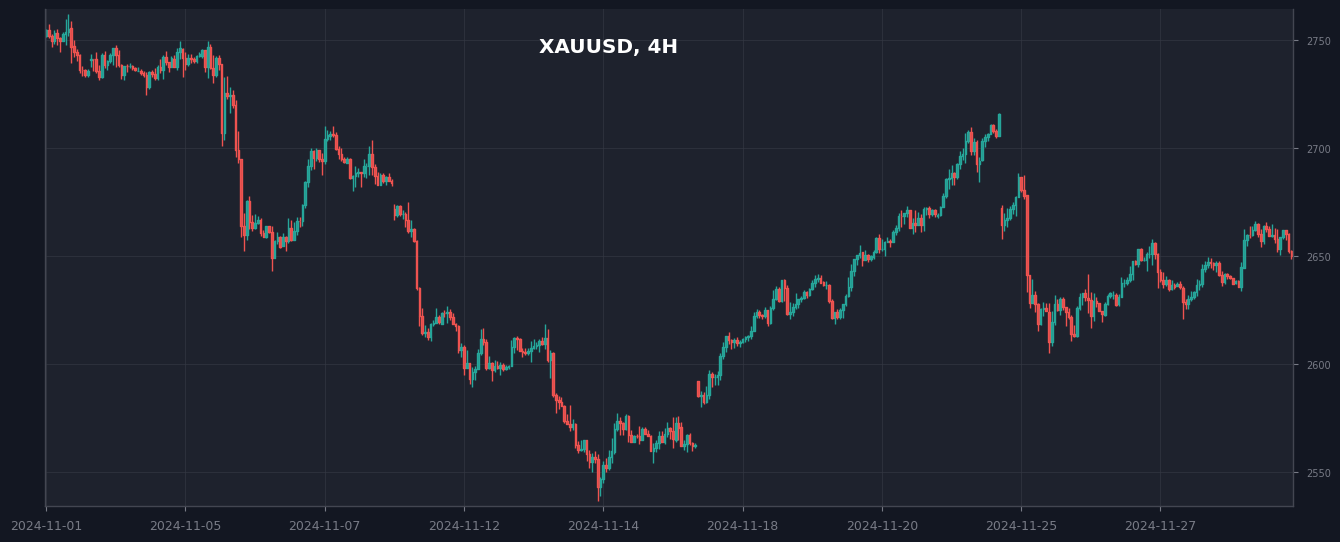

2025-09-23 14:23:35,372 [INFO] Chart eec9f0bf-daca-4fca-811a-324faa307915 generated successfully in 5.84s


In [ ]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd

# Convert DataFrame index to DatetimeIndex
def ensure_datetime_index(df):
    df = df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        # Convert date-only index to DatetimeIndex (assign midnight as default time)
        df.index = pd.to_datetime(df.index)
    return df

# Initialize chartter with wider and less tall proportions, no volume
chartter = Chartter(config={
    'chart_type': 'candle',
    'style': 'charles',
    'figratio': (20, 8),  # Adjusted for wider and less tall chart
    'volume': False  # Disable volume bars
})

# --- TradingView Market Colors ---
tv_mc = mpf.make_marketcolors(
    up='#26a69a',         # TradingView teal green for up candles
    down='#ef5350',       # TradingView red for down candles
    edge='inherit',       # Clean edges matching candle color
    wick='inherit',       # Wicks match candle colors
)

# --- TradingView Dark Theme ---
tradingview_dark = mpf.make_mpf_style(
    base_mpf_style='nightclouds',  # Start with dark base
    marketcolors=tv_mc,

    # TradingView dark theme colors
    figcolor='#131722',           # Dark navy background
    facecolor='#1e222d',          # Dark gray chart area
    gridcolor='#363a45',          # Dark gray grid
    gridstyle='-',                # Solid grid lines

    y_on_right=True,              # Price axis on right

    rc={
        # TradingView typography
        # 'font.family': ['-apple-system', 'BlinkMacSystemFont', 'Trebuchet MS', 'Roboto', 'Ubuntu', 'sans-serif'],
        'axes.labelsize': 10,
        'axes.titlesize': 14,
        'xtick.labelsize': 9,
        'ytick.labelsize': 7,         # Reduced size for price tick labels
        'legend.fontsize': 9,

        # Clean spacing with reduced left padding and full-width chart
        'axes.labelpad': 10,
        'xtick.major.pad': 6,
        'ytick.major.pad': 6,
        'axes.xmargin': 0,            # Remove left/right margins
        'axes.ymargin': 0,            # Remove top/bottom margins
        'figure.subplot.left': 0.05,  # Minimize left subplot padding
        'figure.subplot.right': 0.95, # Maximize right subplot to fit price scale

        # TradingView-style lines
        'lines.linewidth': 1.5,
        'lines.antialiased': True,

        # Clean borders and colors
        'axes.edgecolor': '#434651',  # Darker edge for dark theme
        'axes.linewidth': 1,
        'xtick.color': '#787b86',     # Light gray for x-axis ticks
        'ytick.color': '#787b86',     # Light gray for y-axis ticks
        'axes.labelcolor': 'none',    # Hide axis label color (labels are empty)

        # Grid styling
        'axes.grid': True,
        'axes.axisbelow': True,
        'grid.alpha': 0.6,            # Slightly more transparent for dark theme
        'grid.linewidth': 0.8,

        # Clean spines (show right spine for price scale)
        'axes.spines.left': True,
        'axes.spines.bottom': True,
        'axes.spines.top': False,
        'axes.spines.right': True,    # Show right spine for price scale
        'ytick.right': True,          # Show right y-axis ticks
    }
)

# --- TradingView Configuration ---
tradingview_config = {
    'title': 'XAUUSD, 4H',                # TradingView style title
    'style': tradingview_dark,             # Use dark theme
    'type': 'candle',
    'mav': (20, 50),                      # Common TradingView MAs
    'volume': False,                      # Disable volume bars
    'show_nontrading': False,             # Ensure no extra y-axis spacing
    'datetime_format': '%Y-%m-%d',        # Format x-axis to show date only
    'xlabel': '',                         # Remove x-axis label
    'ylabel': '',                         # Remove y-axis label
    'xrotation': 0                        # Horizontal date labels
}

# --- Execute TradingView Style ---
chartter.plot(
    df=ensure_datetime_index(H1_1M_ohlcv),
    config=tradingview_config
)